## Code for plotting the Excel data exported from the Li-air Arbin cycler

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
file_path = r"C:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_CNTS_1625_23523\Channel_19\lb958_CNTS_1497_23523lb958_CNTS_1625_23523_Channel_19.xlsx"
file_name = file_path.split('\\')[-1]
channel = file_name.split('_')[-2] +'_'+ file_name.split('_')[-1].split('.')[0]
print(channel)

Channel_19


In [3]:
spreadsheet = pd.read_excel(file_path, sheet_name=channel+'_1')
df = pd.DataFrame(spreadsheet)
df.head()

,Date_Time,Test_Time(s),Step_Time(s),Step_Index,Cycle_Index,Voltage(V),Current(A),Charge_Capacity(Ah),Discharge_Capacity(Ah),Charge_Energy(Wh),Discharge_Energy(Wh),Internal Resistance(Ohm),dV/dt(V/s)
0,2023-05-23 14:25:25.403,60.0011,60.0008,1,1,2.820613,0.0,0.0,0.0,0.0,0.0,NaN,0.000004
1,2023-05-23 14:26:25.403,120.0011,120.0008,1,1,2.820640,0.0,0.0,0.0,0.0,0.0,NaN,0.000088
2,2023-05-23 14:27:25.403,180.0010,180.0007,1,1,2.820546,0.0,0.0,0.0,0.0,0.0,NaN,0.000051
3,2023-05-23 14:28:25.403,240.0006,240.0003,1,1,2.820567,0.0,0.0,0.0,0.0,0.0,NaN,0.000072
4,2023-05-23 14:29:25.403,300.0006,300.0003,1,1,2.820580,0.0,0.0,0.0,0.0,0.0,NaN,0.000017


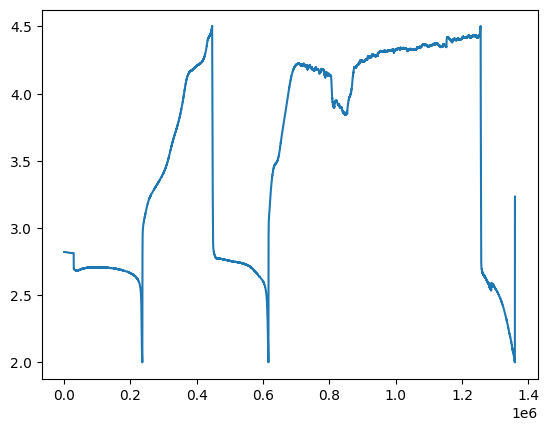

In [4]:
plt.plot(df['Test_Time(s)'], df['Voltage(V)'])

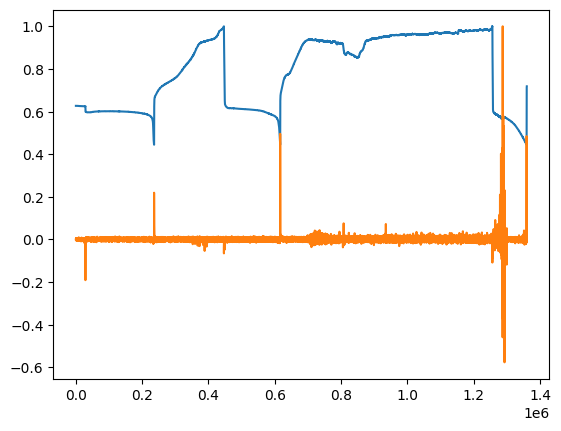

In [5]:
df['dV/dt(V/s)'].head()
plt.plot(df['Test_Time(s)'], df['Voltage(V)']/df['Voltage(V)'].max())
plt.plot(df['Test_Time(s)'], df['dV/dt(V/s)']/df['dV/dt(V/s)'].max())


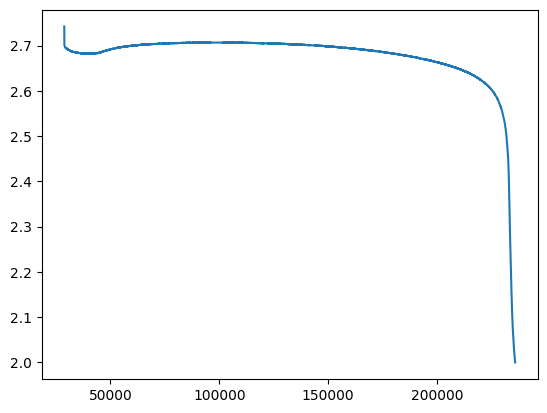

In [6]:
# point where normalised dV/dt exceeds 0.1 for the first time
first_cycle_index_end = np.where(df['dV/dt(V/s)']/df['dV/dt(V/s)'].max() > 0.2)[0][0]
first_cycle_index_start = np.where(df['dV/dt(V/s)']/df['dV/dt(V/s)'].max() < -0.1)[0][0]
#plot the first cycle
df_first_cycle = df[first_cycle_index_start:first_cycle_index_end]
plt.plot(df_first_cycle['Test_Time(s)'], df_first_cycle['Voltage(V)'])



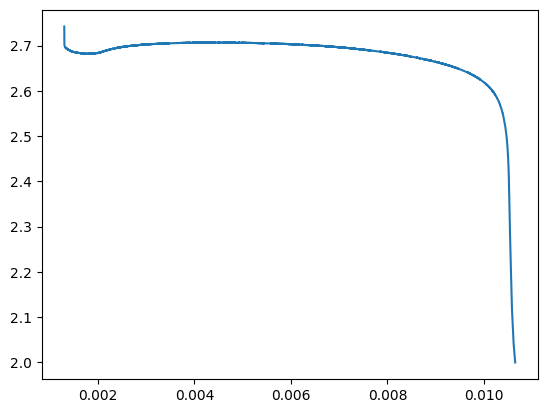

In [7]:

# plots voltage vs (Current * time / 3600) for first cycle
capacity_Ah = df_first_cycle['Test_Time(s)']*df_first_cycle['Current(A)']/-3600
plt.plot(capacity_Ah, df_first_cycle['Voltage(V)'] )



Text(0, 0.5, 'Voltage (V)')

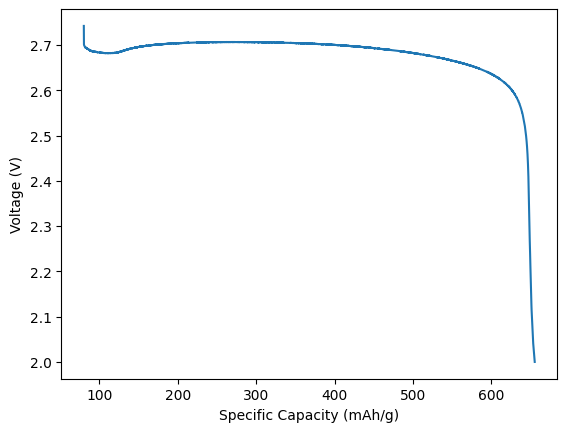

In [8]:
mass = 16.25 / 1000 #grams
specific_capacity_mAhg = capacity_Ah*1000/mass
plt.plot(specific_capacity_mAhg, df_first_cycle['Voltage(V)'] )
plt.xlabel('Specific Capacity (mAh/g)')
plt.ylabel('Voltage (V)')


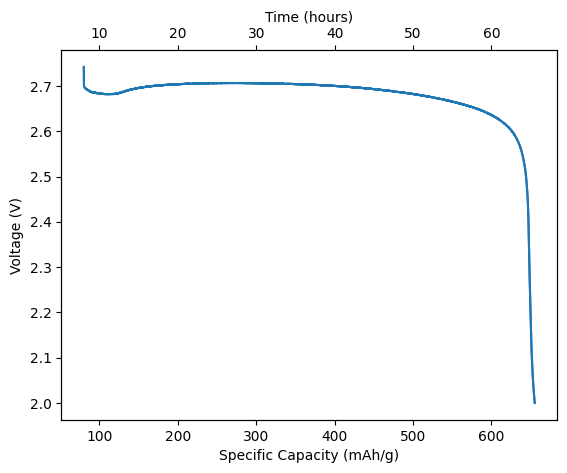

In [9]:
# plot voltage vs specific capacity on the bottom x axis and voltage vs time on the top x axis
fig, ax1 = plt.subplots()
ax2 = ax1.twiny()
ax1.plot(specific_capacity_mAhg, df_first_cycle['Voltage(V)'] )
ax2.plot(df_first_cycle['Test_Time(s)']/3600, df_first_cycle['Voltage(V)'])
ax1.set_xlabel('Specific Capacity (mAh/g)')
ax1.set_ylabel('Voltage (V)')
ax2.set_xlabel('Time (hours)')
plt.show()


In [10]:
print(specific_capacity_mAhg)

481       80.023273
482       80.052080
483       80.079398
484       80.108609
485       80.136386
            ...    
21188    655.228422
21189    655.247751
21190    655.278817
21191    655.303307
21192    655.315139
Length: 20712, dtype: float64
